# Porównanie skuteczności klasyfikatorów SVM i AdaBoost na zbiorach danych o wymiarowości zredukowanej przez autoenkoder wariacyjny

## Przygotowanie zbioru danych

In [1]:
%matplotlib inline

import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
with zipfile.ZipFile("data/fashion-mnist.zip") as z:
    with z.open("fashion-mnist_train.csv") as f:
        train_df = pd.read_csv(f)

    with z.open("fashion-mnist_test.csv") as f:
        test_df = pd.read_csv(f)

train_labels = train_df['label'].to_numpy()
train_data = train_df.drop('label', axis='columns').to_numpy() / 255.0

test_labels = test_df['label'].to_numpy()
test_data = test_df.drop('label', axis='columns').to_numpy() / 255.0

W projekcie wykorzystujemy zbiór danych FMNIST.

Jako że jest to bardzo znany i dokładnie opisany zbiór danych, etap eksploracji danych ograniczyliśmy do minimum - wszelkie ważne własności zbioru zostały już zbadane, więc sprawdzanie ich w miarę potrzeb nie nastręcza większych trudności. Tutaj zaglądamy jedynie na początek danych oraz podstawową ich charakterystykę, aby upewnić się, że wszystko jest w porządku.

In [3]:
def print_images(images, title):
    fig, axs = plt.subplots(ncols=5, figsize=(13,4))
    
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

    fig.tight_layout()
    fig.suptitle(title, fontsize=15)
    plt.show()

Liczba próbek w zbiorze uczącym: 60000
Liczba próbek w zbiorze testowym: 10000

Kształt wektora wejściowego: (785,)
Zakres wartości pikseli przed normalizacją: 0 - 255


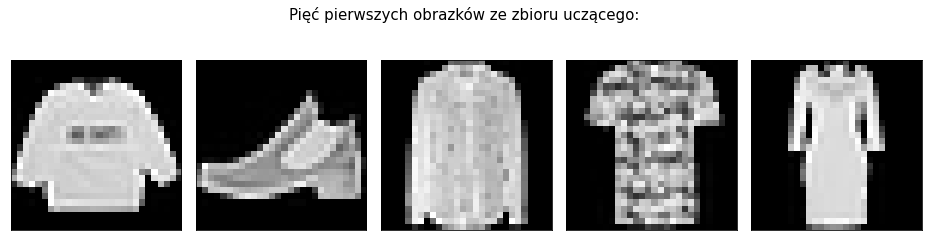

Reprezentacja pierwszych 5 próbek w zbiorze uczącym:

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel78

In [5]:
print(f'Liczba próbek w zbiorze uczącym: {len(train_df)}')
print(f'Liczba próbek w zbiorze testowym: {len(test_df)}')
print()
print(f'Kształt wektora wejściowego: {np.shape(train_df.iloc[0])}')
print(f'Zakres wartości pikseli przed normalizacją: {np.min(train_df.to_numpy())} - {np.max(train_df.to_numpy())}')

first_5_images = train_df.head().drop('label', axis='columns').to_numpy().reshape((5,28,28))
print_images(first_5_images, 'Pięć pierwszych obrazków ze zbioru uczącego:')
    
print('Reprezentacja pierwszych 5 próbek w zbiorze uczącym:\n')
print(train_df.head())

## Redukcja wymiarowości za pomocą autoenkodera wariacyjnego

In [6]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives
from enum import Enum

Using TensorFlow backend.


### Załadowanie modeli

Modele zostały zbudowane i wytrenowane w osobnym notatniku Jupyter: *'Autoenkodery - tworzenie i trening'*.

W ramach projektu wykorzystano 3 architektury sieci - są to (wg rosnącej złożoności):
 * enkoder wariacyjny z 2 warstwami ukrytymi
 * enkoder wariacyjny z 4 warstwami ukrytymi
 * enkoder konwolucyjno-wariacyjny

Każda z architektur została wytrenowana w trzech wersjach - dla 15, 50 i 100 wymiarów w środkowej warstwie sieci.

Trening sieci o bardziej złożonej architekturze wymaga więcej czasu - w tym przypadku, pojedyncza epoka treningu najbardziej złożonej sieci (konwolucyjno-wariacyjnej) trwała 10 razy dłużej niż najprostszej z nich (2 warstwy ukryte). Wykorzystanie modeli o różnej złożoności odpowiada zatem posiadaniu odpowiednio zróżnicowanego budżetu czasowego.

In [8]:
z_mean, z_variance = None, None

def load_model(model_name):
    with open(f'autoencoders/models/{model_name}.json') as file:
        loaded_json = file.read()
    return model_from_json(loaded_json)

def load_weights(model, model_name, epochs):
    model.load_weights(f'autoencoders/weights/{model_name}_e{epochs}.h5')

def load_encoder(time, dim, epochs=400):
    global z_mean, z_variance
    
    encoder_name = f'encoder_{time.value}_d{dim.value}'
    
    encoder = load_model(encoder_name)
    load_weights(encoder, encoder_name, epochs)
    
    z_mean, z_variance = encoder.get_layer('z_mean').output, encoder.get_layer('z_variance').output
    encoder.compile(optimizer='rmsprop', loss='mean_squared_error')
    
    return encoder

In [9]:
class Time(Enum):
    SHORT = '2hl'
    MEDIUM = '4hl'
    LONG = 'cvae'

class Dim(Enum):
    LOW = 15
    MEDIUM = 50
    HIGH = 100

# encoders[dimension][time]

encoders = {dim: {time: load_encoder(time, dim, 400 if time != Time.LONG else 300) for time in Time} for dim in Dim}

### Generowanie zbiorów danych o zredukowanej wymiarowości

In [10]:
batch_size = 10000
initial_dim = 784

In [11]:
# reduced_datasets[Dim][Time]['train'|'test']

def reduce_dimensionality(train, test):
    return {
                dim: {
                    time: {
                        'train': encoders[dim][time].predict(train, batch_size=batch_size),
                        'test': encoders[dim][time].predict(test, batch_size=batch_size)
                    } for time in Time
                } for dim in Dim
            }

def map_over_reduced(reduced_datasets, f, args):
    return {dim: {
                time: {
                    key: f(reduced_datasets[dim][time][key], *args) for key in reduced_datasets[dim][time]
                } for time in reduced_datasets[dim].keys()
            } for dim in reduced_datasets.keys()}

In [12]:
reduced_datasets = reduce_dimensionality(train_data, test_data)

## Klasyfikacja

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

In [14]:
from joblib import dump, load

In [15]:
def get_classifier_filename(name, dim, time, noise_factor, noise_type):
    return f'{name}_{time.value}_d{dim.value}' + (
        f'_n{str(noise_factor).split(".")[1]}_{noise_type}' if noise_type is not None else ''
    )

def get_orig_classifier_filename(name, noise_factor, noise_type):
    return f'{name}_orig' + (f'_{str(noise_factor).split(".")[1]}_{noise_type}' if noise_type is not None else '')

def get_classifier_path(name, filename):
    return f'{name}/{filename}'

def persist_classifier(classifier, name, dim, time, noise_factor, noise_type):
    filename = get_classifier_filename(name, dim, time, noise_factor, noise_type)
    path = get_classifier_path(name, filename)
    dump(classifier, path)

def persist_orig_classifier(classifier, name, noise_factor, noise_type):
    filename = get_orig_classifier_filename(name, noise_factor, noise_type)
    path = get_classifier_path(name, filename)
    dump(classifier, path)

def load_classifier(name, dim, time, noise_factor, noise_type):
    filename = get_classifier_filename(name, dim, time, noise_factor, noise_type)
    path = get_classifier_path(name, filename)
    return load(path)

def load_orig_classifier(name, noise_factor, noise_type):
    filename = get_orig_classifier_filename(name, noise_factor, noise_type)
    path = get_classifier_path(name, filename)
    return load(path)

def persist_fitted_clfs(name, orig, applied, noise_factor, noise_type):
    orig_fitted, _ = orig
    persist_orig_classifier(orig_fitted, name, noise_factor, noise_type)
    
    for dim, time, (fitted, _) in applied:
        persist_classifier(fitted, name, dim, time, noise_factor, noise_type)

In [47]:
def fit_predict(model, train_data, train_labels, test_data):
    print(f'Fitting model {model}')
    
    fitted = model.fit(train_data, train_labels)

    print(f'Predicting with model {model}')
    
    predicted = fitted.predict(test_data)
    
    print()
    
    return fitted, predicted

def apply_classifier(classifier_class, original_dataset, reduced_datasets):
    orig_train_data, orig_train_labels, orig_test_data, orig_test_labels = original_dataset
    
    orig = fit_predict(classifier_class(), orig_train_data, orig_train_labels, orig_test_data)
    
    applied = [(dim, time, fit_predict(classifier_class(),
                                       reduced_datasets[dim][time]['train'],
                                       orig_train_labels,
                                       reduced_datasets[dim][time]['test']
                                       ))
              for dim in Dim for time in Time]
    
    return orig, applied  

def print_accuracy_scores(classifier_name, orig, applied, original_dataset):
    _, orig_predicted = orig
    _, _, _, orig_test_labels = original_dataset
    
    print(f'{classifier_name} accuracy scores:')
    print(f'original dataset: {accuracy_score(orig_test_labels, orig_predicted)}')
    
    acc = []
    labels = []
    
    for dim, time, (_, predicted) in applied:
        print(f'dimension {dim.name}, time {time.name}: {accuracy_score(orig_test_labels, predicted)}')
        labels.append(f'dimension {dim.name}, time {time.name}')
        acc.append(accuracy_score(orig_test_labels, predicted))
        
    labels.append('original')
    acc.append(accuracy_score(orig_test_labels, orig_predicted))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(labels, acc)
    #fig.autofmt_xdate()
    plt.show()
    return labels, acc
    
    

def print_classification_reports(classifier_name, orig, applied, original_dataset):
    _, orig_predicted = orig
    _, _, _, orig_test_labels = original_dataset
    
    labels = []
    acc = []
    
    print('----- Classification for original dataset -----')
    print(classification_report(orig_test_labels, orig_predicted))
    

    
    
    for dim, time, (_, predicted) in applied:
        print(f'----- Classification for dimension {dim.name}, time {time.name} -----')
        print(classification_report(orig_test_labels, predicted))
        labels.append(f'dimension {dim.name}, time {time.name}')
        acc.append(classification_report(orig_test_labels, predicted, output_dict=True)['accuracy'])
        
    labels.append('original')
#     d = classification_report(orig_test_labels, orig_predicted, output_dict=True)
#     for key, value in d.items():
#         print (key, value)
    acc.append(classification_report(orig_test_labels, orig_predicted, output_dict=True)['accuracy'])
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(labels, acc)
    #fig.autofmt_xdate()
    plt.show()
    return labels, acc

In [48]:
clf = load_classifier('adaboost', Dim.LOW, Time.SHORT, 0.0, None)

In [49]:
clf

AdaBoostClassifier()

### AdaBoost

In [50]:
def measure_adaboost(original_dataset, reduced_datasets, noise_factor=0.0, noise_type=None):  
    orig, applied = apply_classifier(AdaBoostClassifier, original_dataset, reduced_datasets)
    
    persist_fitted_clfs('adaboost', orig, applied, noise_factor, noise_type)
    
    return print_accuracy_scores('AdaBoost', orig, applied, original_dataset)

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

AdaBoost accuracy scores:
original dataset: 0.5612
dimension LOW, time SHORT: 0.286
dimension LOW, time MEDIUM: 0.3075
dimension LOW, time LONG: 0.3339
dimension MEDIUM, time SHORT: 0.363
dimension MEDIUM, time

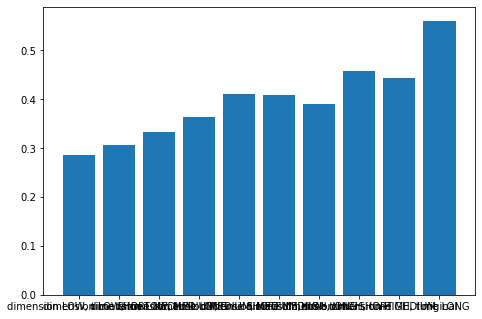

In [51]:
ada_labels, ada_acc = measure_adaboost((train_data, train_labels, test_data, test_labels), reduced_datasets)

### SVM

In [52]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
def limited(array, n):
    return array[:n] if len(array) > n else array

def limit_dataset(dataset, target_number_of_samples):
    return (limited(array, target_number_of_samples) for array in dataset)

In [62]:
orig, applied = None, None

def measure_svc(original_dataset, reduced_datasets, sample_limit=10000, noise_factor=0.0, noise_type=None):
    global orig, applied
    
    limited_dataset = limit_dataset(original_dataset, sample_limit)
    limited_reduced_datasets = map_over_reduced(reduced_datasets, limited, (sample_limit,))
    
    orig, applied = apply_classifier(SVC, limited_dataset, limited_reduced_datasets)
    
    persist_fitted_clfs('svm', orig, applied, noise_factor, noise_type)
    
    return print_classification_reports('SVC', orig, applied, original_dataset)

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

Fitting model SVC()
Predicting with model SVC()

----- Classification for original dataset -----
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.99      0.96      0.98      1000
           2       0.81      0.77      0.79      1000
           3       0.85      0.91      0.88      1000
           4       0.79      0.83      0.81      1000
           5       0.95      0.92      0.93      1000
           6       0.66      0.59      0.62      1000
           7       0.91      

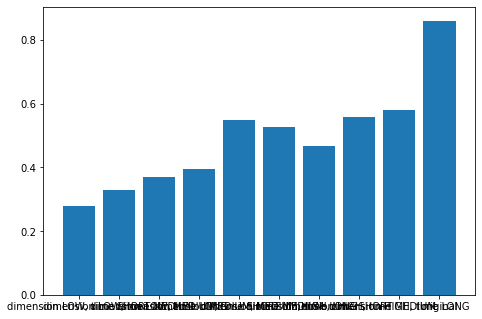

In [63]:
svm_labels, svm_acc = measure_svc((train_data, train_labels, test_data, test_labels), reduced_datasets)

### Porównanie klasyfikatorów

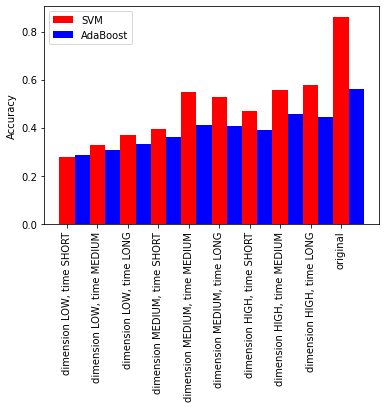

In [77]:
#print(ada_labels)
ax = plt.subplot(111)
x = [x for x in range(10)]
xx = [x+0.5 for x in range(10)]
svm_legend = ax.bar(x, svm_acc, width=0.5, color='r')
ada_legend = ax.bar(xx, ada_acc, width=0.5, color='b')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(ada_labels, rotation=90)
ax.legend((svm_legend, ada_legend), ('SVM', 'AdaBoost'))
ax.autoscale()
plt.show()

##### Dla oryginalnych danych klasyfikator SVM w przypadku zbioru fashion mnist odznacza się znacznie większą precyzją. 
##### Zmniejszenie wymiarowości zbioru znacznie pogarsza wyniki klasyfikacji, chociaż klasyfikator SVM osiąga lepszą celność dla prawie wszystkich przypadków testowych, to klasyfikator AdaBoost wydaje się być mniej wrażliwy na zmniejszanie wymiarowości i zasobów czasowych liczenia. W jego przypadku słupki różnią się o mniejsze wartości. Szczególnie widać to dla namniejszej wymiarowości i czasu uczenia, gdzie klasyfikator AdaBoost osiągnął lepszą precyzję od SVM. Widać, że wraz ze zmniejszaniem czasu uczenia i wymiarowości danych wykresy słupkowe przedstawiające precyzję obu klasyfikatorów się do siebie zbliżają.

## Pomiar odporności klasyfikatorów na zaszumione dane (*robustness*)

### Zaszumienie wektorów danych

In [40]:
def noisify_vectors(data, noise_factor):    
    vector_length = len(data[0])
    number_of_samples = len(data)
    epsilon = (np.random.rand(number_of_samples, vector_length) - 0.5) * 2 * 255 * noise_factor
    new_data = data + epsilon
    bounded = lambda p: min(max(p, 0), 255)
    return np.vectorize(bounded)(new_data)

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

AdaBoost accuracy scores:
original dataset: 0.1173
dimension LOW, time SHORT: 0.0976
dimension LOW, time MEDIUM: 0.1133
dimension LOW, time LONG: 0.1108
dimension MEDIUM, time SHORT: 0.0973
dimension MEDIUM, ti

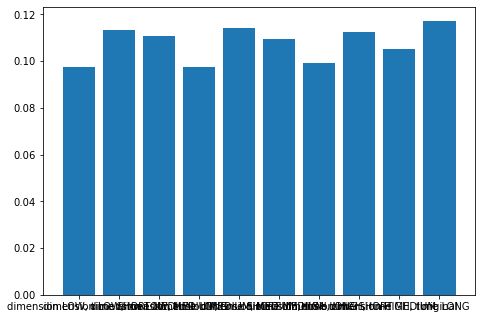

TypeError: slice indices must be integers or None or have an __index__ method

In [43]:
noise_factors = np.linspace(0.1, 0.5, 3)
noise_type = 'vectors'

for noise_factor in noise_factors:
    noisy_train_data = noisify_vectors(train_data, noise_factor)
    noisy_test_data = noisify_vectors(test_data, noise_factor)
    
    noisy_original_dataset = (noisy_train_data, train_labels, noisy_test_data, test_labels)
    
    noisy_reduced_datasets = reduce_dimensionality(noisy_train_data, noisy_test_data)
    
    measure_adaboost(noisy_original_dataset, noisy_reduced_datasets, noise_factor, noise_type)
    measure_svc(noisy_original_dataset, noisy_reduced_datasets, noise_factor, noise_type)

### Zaszumienie etykiet

In [44]:
from copy import deepcopy

def noisify_labels(labels, ratio):
    new_labels = deepcopy(labels)
    distinct_labels = np.unique(labels)
    indices = np.random.choice(len(labels), int(ratio * len(labels)), replace=False)
    for i in indices:
        current_label = new_labels[i]
        possible_labels = [l for l in distinct_labels if l != current_label]
        new_labels[i] = np.random.choice(possible_labels, 1)[0]
    return new_labels

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

Fitting model AdaBoostClassifier()
Predicting with model AdaBoostClassifier()

AdaBoost accuracy scores:
original dataset: 0.7447
dimension LOW, time SHORT: 0.2857
dimension LOW, time MEDIUM: 0.3056
dimension LOW, time LONG: 0.3584
dimension MEDIUM, time SHORT: 0.3508
dimension MEDIUM, ti

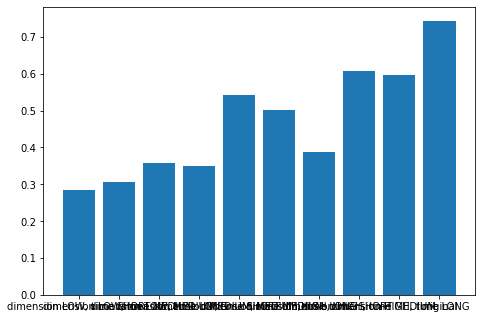

TypeError: slice indices must be integers or None or have an __index__ method

In [46]:
noise_factors = np.linspace(0.1, 0.5, 3)
noise_type = 'labels'

for noise_factor in noise_factors:
    noisified_original_dataset = (train_data, noisify_labels(train_labels, noise_factor), test_data, test_labels)
    
    measure_adaboost(noisified_original_dataset, reduced_datasets, noise_factor, noise_type)
    measure_svc(noisified_original_dataset, reduced_datasets, noise_factor, noise_type)

## Źródła

* https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726
* https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://www.tensorflow.org/tutorials/generative/cvae
* https://towardsdatascience.com/the-robustness-of-machine-learning-algorithms-against-missing-or-abnormal-values-ec3222379905